# Initializing Libraries

In [2]:
import pandas as pd
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer
from nltk.tokenize import word_tokenize

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

# Reading Dataset

In [3]:
df = pd.read_csv("/content/all_brands_combined_mobile_data_final.csv")
df.head()

Post ID                                               Text Product Brand
0       0  As someone who previously owned an Apple flags...  Google Pixel
1       1  Téléphone portable pixels 9 pro très satisfait...  Google Pixel
2       2  Good phone, but it does not have the best batt...  Google Pixel
3       3  Hello Buyer,\n\nI recently purchased the Pixel...  Google Pixel
4       4  Okay, so my old phone was 6 years old and it s...  Google Pixel

# Pre-processing steps

In [4]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    # Remove special characters and numbers
    text = re.sub(r'[^a-zA-Z\s]', ' ', text)

    # Convert to lowercase
    text = text.lower()

    # Tokenize
    tokens = text.split()

    # Remove stopwords and lemmatize
    processed_tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]

    return " ".join(processed_tokens)

df['Processed_Text'] = df['Text'].apply(preprocess_text)

# Taking subset of all reviews (Top 2000 reviews for each brand)

In [5]:
# Group by 'Product Brand' and select the first 2000 rows for each group
df_sampled = df.groupby('Product Brand').head(2000)

# Now df_sampled contains the first 2000 rows for each 'Product Brand'
df_sampled.head()

Post ID                                               Text Product Brand  \
0       0  As someone who previously owned an Apple flags...  Google Pixel   
1       1  Téléphone portable pixels 9 pro très satisfait...  Google Pixel   
2       2  Good phone, but it does not have the best batt...  Google Pixel   
3       3  Hello Buyer,\n\nI recently purchased the Pixel...  Google Pixel   
4       4  Okay, so my old phone was 6 years old and it s...  Google Pixel   

                                      Processed_Text  
0  someone previously owned apple flagship samsun...  
1  l phone portable pixel pro tr satisfait bon pr...  
2                       good phone best battery life  
3  hello buyer recently purchased pixel pro pixel...  
4  okay old phone year old still work thought tre...

## Getting similar word for attributes in all the reviews using S-BERT

In [6]:
# Sample Reviews Dataset (Replace this with actual data)
reviews = df['Processed_Text'].tolist()

# Preprocessing function
def preprocess_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(f"[{string.punctuation}]", "", text)  # Remove punctuation
    words = word_tokenize(text)  # Tokenization
    return words

# Tokenize reviews
tokenized_reviews = [preprocess_text(review) for review in reviews]

# Flatten the list to get unique words
unique_words = list(set([word for review in tokenized_reviews for word in review]))

print(f"Total unique words: {len(unique_words)}")


Total unique words: 17724


In [7]:
# Load Sentence-BERT model
bert_model = SentenceTransformer('all-MiniLM-L6-v2')

# Encode all words in the dataset
word_embeddings = bert_model.encode(unique_words)

# Encode attributes
attributes = ['battery', 'camera', 'screen', 'performance', 'design', 'software', 'display', 'speaker']
attribute_embeddings = bert_model.encode(attributes)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [8]:
# Find the closest words to each attribute
def get_closest_words(attribute, top_n=10):
    attr_embedding = bert_model.encode([attribute])  # Encode attribute
    similarities = cosine_similarity(attr_embedding, word_embeddings)[0]  # Compute cosine similarity
    closest_indices = np.argsort(similarities)[-top_n:][::-1]  # Get top N similar words
    return [unique_words[idx] for idx in closest_indices]

# Get related words for each attribute
related_words = {attr: get_closest_words(attr) for attr in attributes}

# Print related words
for attr, words in related_words.items():
    print(f"{attr}: {words}")


battery: ['battery', 'batterylife', 'charge', 'recharged', 'recharge', 'battere', 'batterry', 'recharger', 'charged', 'batter']
camera: ['camera', 'cameraphone', 'motioncam', 'photography', 'camerawise', 'photograph', 'webcam', 'polycam', 'photographic', 'nikon']
screen: ['screen', 'onscreen', 'lcd', 'homescreen', 'testmyscreen', 'screentime', 'monitor', 'screenshoting', 'touchscreen', 'display']
performance: ['performance', 'efficiency', 'slower', 'efficient', 'performs', 'speed', 'benchmark', 'slowness', 'slowdown', 'efficiently']
design: ['design', 'designing', 'designed', 'designer', 'designster', 'architecture', 'architectural', 'aesthetic', 'redesigns', 'style']
software: ['software', 'program', 'softwarewise', 'programing', 'application', 'microsoft', 'programming', 'adobe', 'computerized', 'apps']
display: ['display', 'displaying', 'displayed', 'showing', 'screen', 'monitor', 'rendered', 'viewing', 'show', 'shown']
speaker: ['speaker', 'speakerphone', 'loudspeaker', 'audio', 'a

## Getting adjectives for the attributes

In [9]:
!pip install nltk spacy
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 70.7 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [10]:
import nltk
import spacy
from nltk.tokenize import word_tokenize
from collections import defaultdict

nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger')

# Load SpaCy Model
nlp = spacy.load("en_core_web_sm")

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


## Getting adjectives (singleton and n-grams) for attributes using spacy

In [11]:
import re
import spacy
import pandas as pd
from collections import defaultdict

# Load spaCy model
# nlp = spacy.load("en_core_web_sm")

# Define attributes and their variations
attributes_keywords = {
    "battery": ['battery', 'batterylife', 'charge', 'recharged', 'recharge', 'battere', 'batterry', 'recharger', 'charged', 'batter'],
    "camera": ['camera', 'cameraphone', 'motioncam', 'photography', 'camerawise', 'photograph', 'webcam', 'polycam', 'photographic', 'nikon'],
    "screen": ['screen', 'onscreen', 'lcd', 'homescreen', 'testmyscreen', 'screentime', 'monitor', 'screenshoting', 'touchscreen', 'display'],
    "performance": ['performance', 'efficiency', 'slower', 'efficient', 'performs', 'speed', 'benchmark', 'slowness', 'slowdown', 'efficiently'],
    "design": ['design', 'designing', 'designed', 'designer', 'designster', 'architecture', 'architectural', 'aesthetic', 'redesigns', 'style'],
    "software": ['software', 'program', 'softwarewise', 'programing', 'application', 'microsoft', 'programming', 'adobe', 'computerized', 'apps'],
    "display": ['display', 'displaying', 'displayed', 'showing', 'screen', 'monitor', 'rendered', 'viewing', 'show', 'shown'],
    "speaker": ['speaker', 'speakerphone', 'loudspeaker', 'audio', 'acoustic', 'sound', 'voice', 'speak', 'hearing', 'speech']
}

# Function to clean text
def clean_text(text):
    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = re.sub(r'[^\w\s]', '', text)  # Remove special characters
    return text.lower()

# Function to extract adjectives & n-grams for each brand
def extract_brandwise_attributes(df, attributes_keywords):
    brand_attribute_data = defaultdict(lambda: defaultdict(lambda: {"single_words": set(), "ngrams": set()}))

    # Iterate over each row in the dataframe
    for _, row in df.iterrows():
        brand = row["Product Brand"]  # Extract brand name
        text = row["Text"]  # Extract review text

        cleaned_text = clean_text(text)
        doc = nlp(cleaned_text)

        for token in doc:
            for attribute, synonyms in attributes_keywords.items():
                if token.lemma_ in synonyms:  # If token matches any attribute synonym
                    adj_phrases = []

                    # Extract single adjectives modifying the attribute
                    for child in token.children:
                        if child.dep_ in ('amod', 'acomp') and child.pos_ == 'ADJ':
                            brand_attribute_data[brand][attribute]["single_words"].add(child.text)
                            adj_phrases.append(child.text)

                    # Extract left-side modifiers (like "super fast")
                    left_modifiers = []
                    for left in token.lefts:
                        if left.pos_ in ["ADV", "ADJ"]:  # Capture adverbs/adjectives
                            left_modifiers.append(left.text)

                    # Remove duplicate words and ensure proper n-grams
                    if adj_phrases:
                        for adj in adj_phrases:
                            words = list(dict.fromkeys(left_modifiers + [adj]))  # Remove duplicates
                            bigram = " ".join(words)  # e.g., "super fast"
                            trigram = " ".join(words + [token.text])  # e.g., "super fast battery"

                            if len(bigram.split()) > 1:  # Ensure it's a valid bigram
                                brand_attribute_data[brand][attribute]["ngrams"].add(bigram)
                            if len(trigram.split()) > 1:  # Ensure it's a valid trigram
                                brand_attribute_data[brand][attribute]["ngrams"].add(trigram)

    # Convert sets to lists for easy JSON serialization
    for brand in brand_attribute_data:
        for attribute in brand_attribute_data[brand]:
            brand_attribute_data[brand][attribute]["single_words"] = list(brand_attribute_data[brand][attribute]["single_words"])
            brand_attribute_data[brand][attribute]["ngrams"] = list(brand_attribute_data[brand][attribute]["ngrams"])

    return brand_attribute_data

# Apply the function to extract brand-wise attributes
brandwise_results = extract_brandwise_attributes(df_sampled, attributes_keywords)

# Display results
for brand, attributes in brandwise_results.items():
    print(f"\nBrand: {brand}")
    for attr, data in attributes.items():
        print(f"  {attr.capitalize()}:")
        print(f"    Single Words: {data['single_words']}")
        print(f"    N-Grams: {data['ngrams']}")



Brand: Google Pixel
  Camera:
    Single Words: ['newer', 'tiny', 'good', 'still', 'mobile', 'actual', 'algorithmic', 'old', 'occasional', 'highend', 'robust', 'better', 'blackmagic', 'inferior', 'nice', 'front', 'mediocre', 'computational', 'rear', 'sure', 'ff', 'great', 'handy', 'real', 'recent', 'best', 'pro', 'portable', 'pixel', 'dedicated', 'amazing', 'android', 'light', 'awesome', 'same', 'useful', 'slim', 'ultrawide', 'faster', 'requirement', 'excellent', 'main']
    N-Grams: ['highend portable', 'excellent camera', 'pixel pro great', 'pixel pro great camera', 'requirement good', 'amazing camera', 'algorithmic photography', 'front camera', 'robust camera', 'mediocre cameras', 'highend portable camera', 'pixel camera', 'better cameras', 'basically same camera', 'blackmagic pro camera', 'real camera', 'better camera', 'great camera', 'recent cameras', 'occasional camera', 'blackmagic pro', 'android camera', 'best camera', 'good especially', 'rear cameras', 'requirement good came

# Wordclouds for each brand-attribute pair

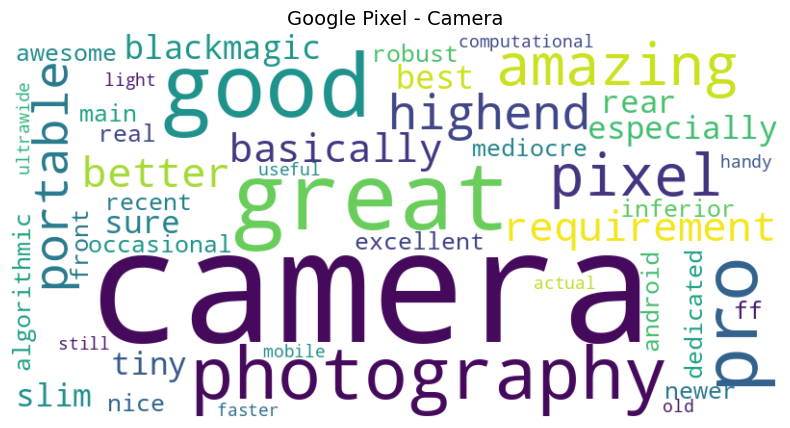

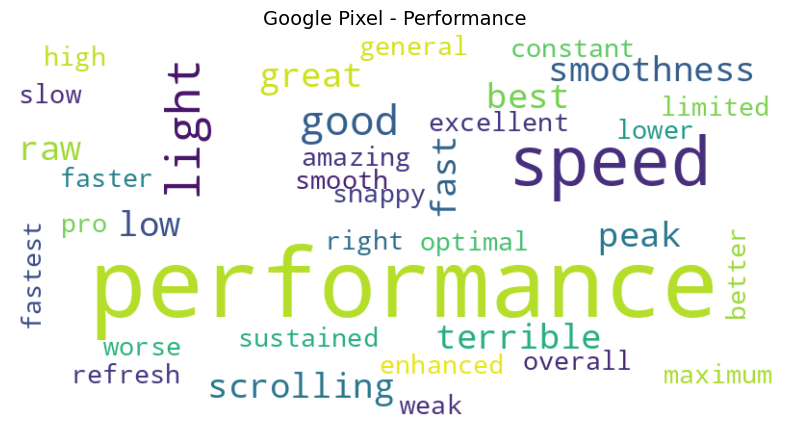

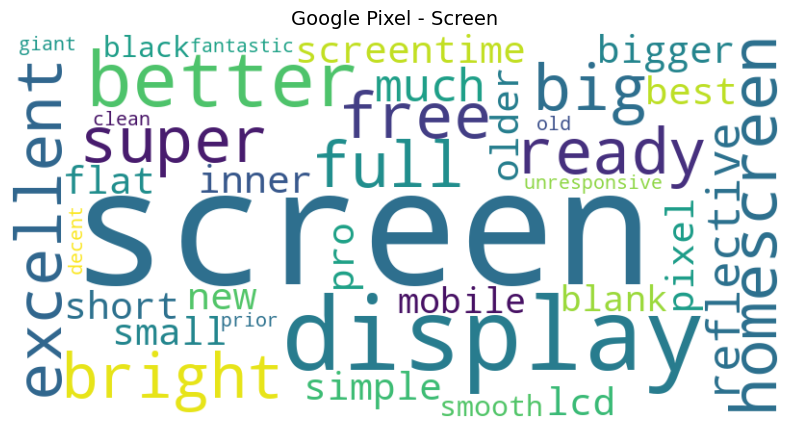

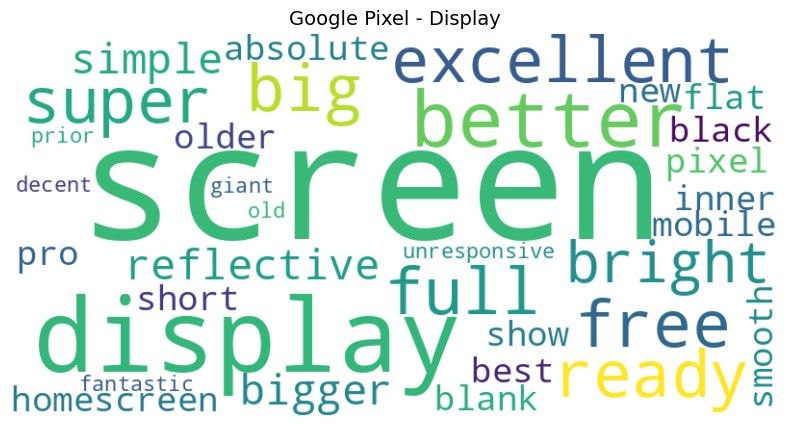

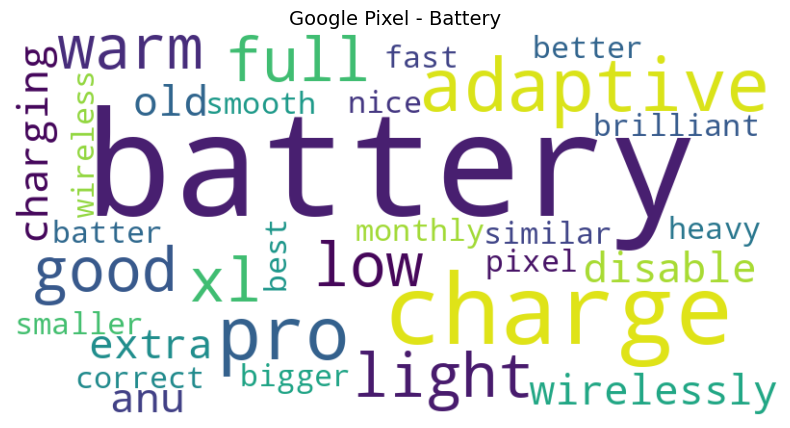

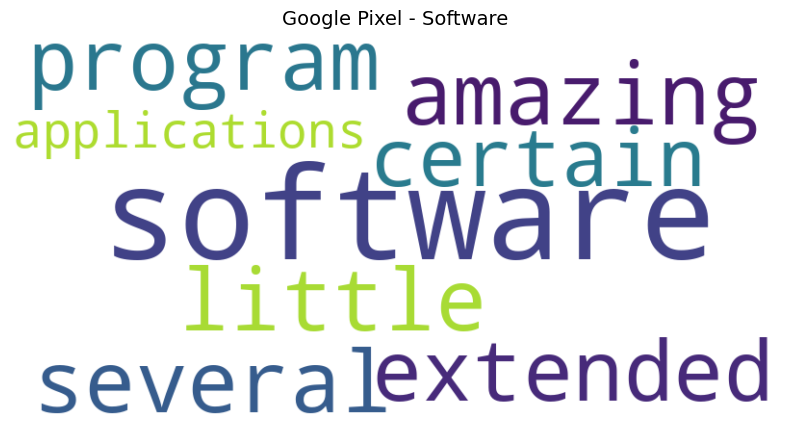

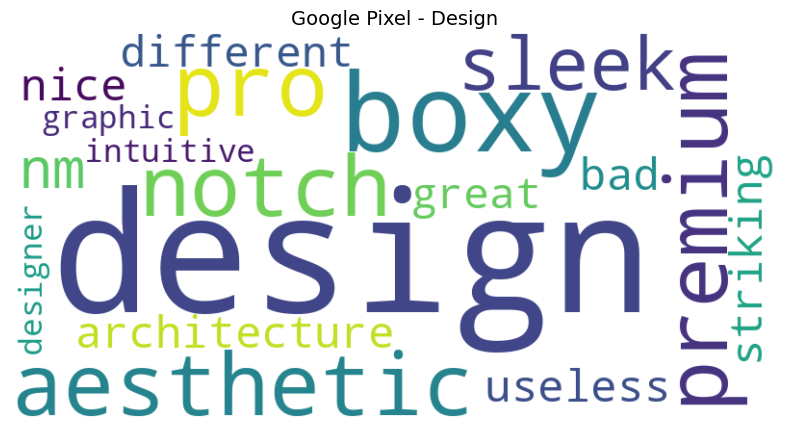

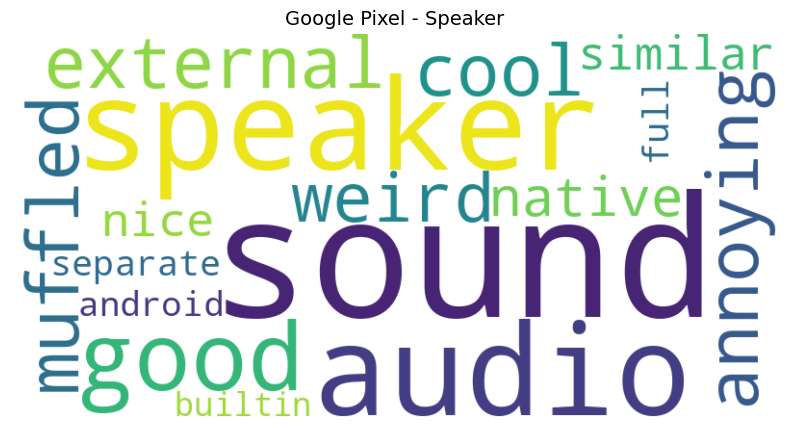

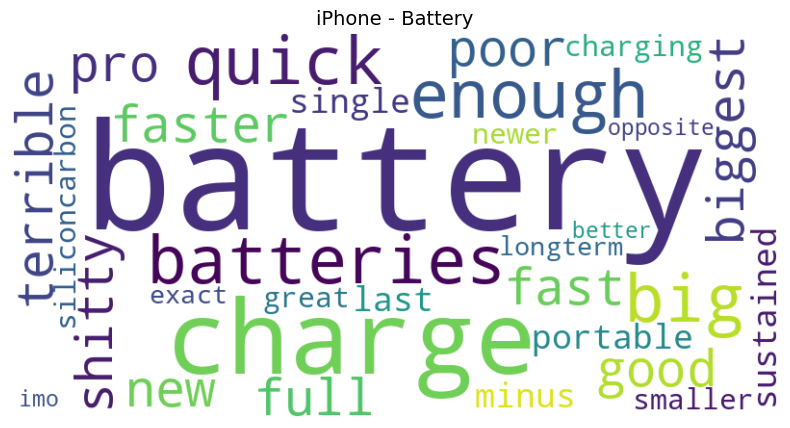

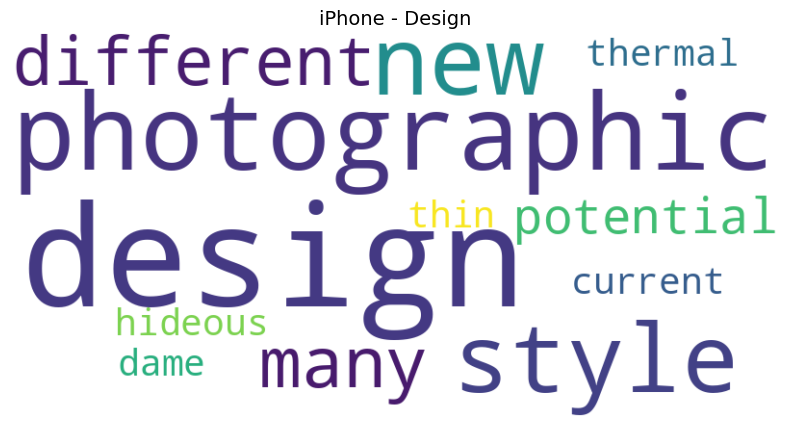

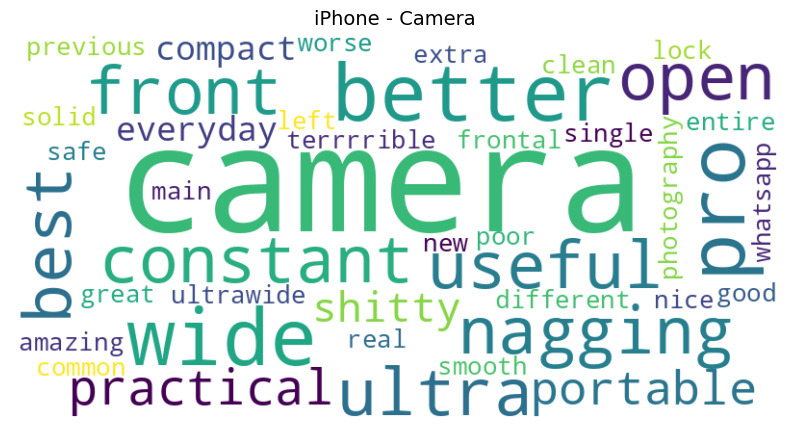

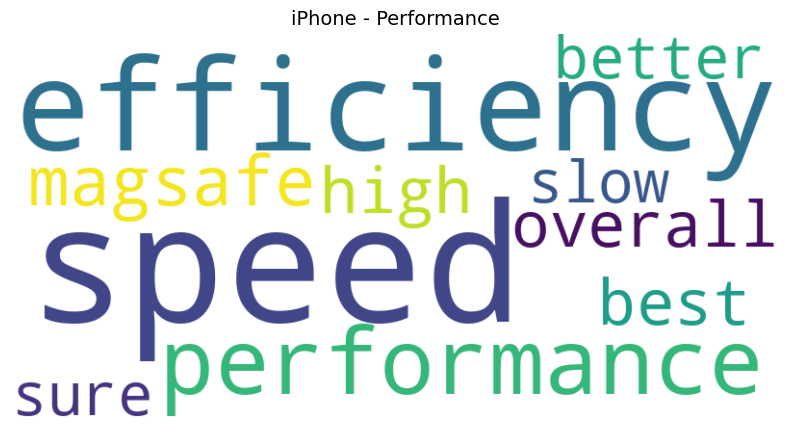

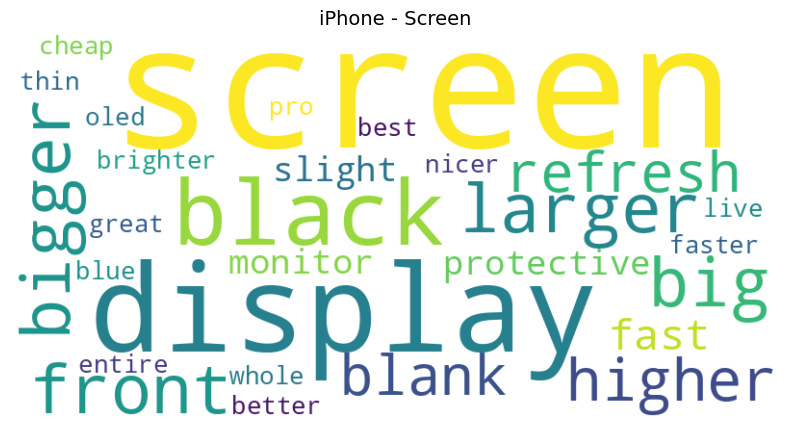

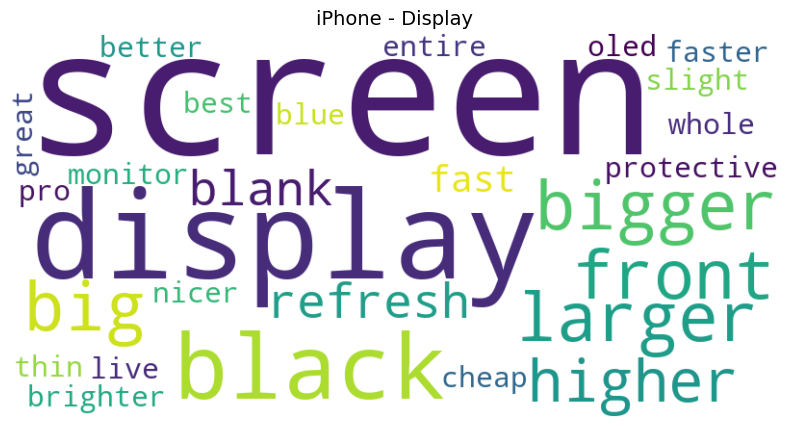

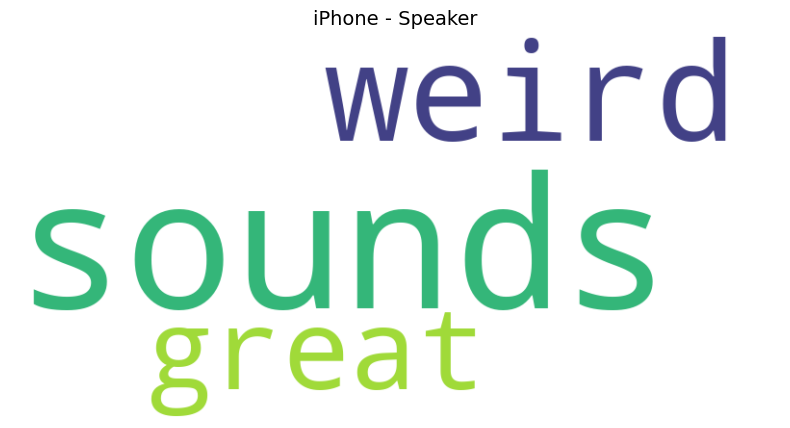

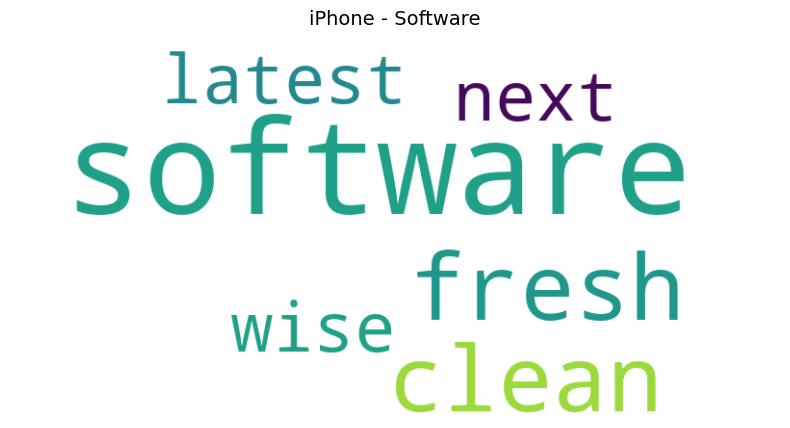

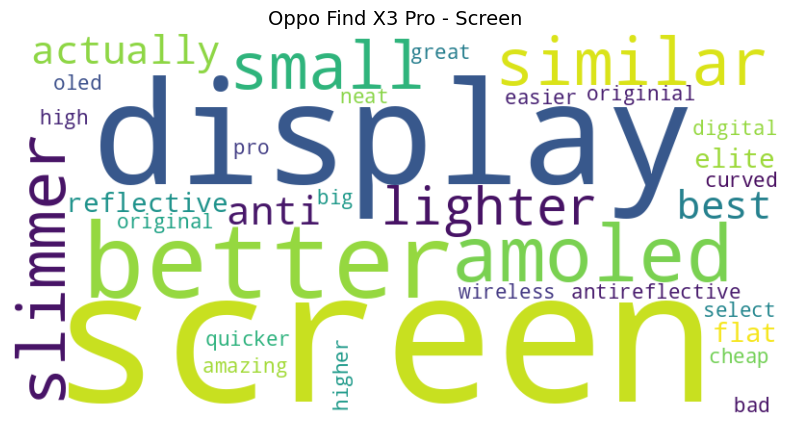

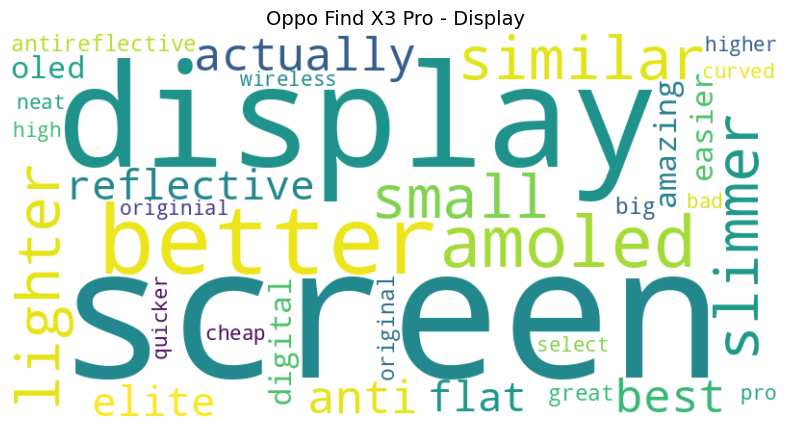

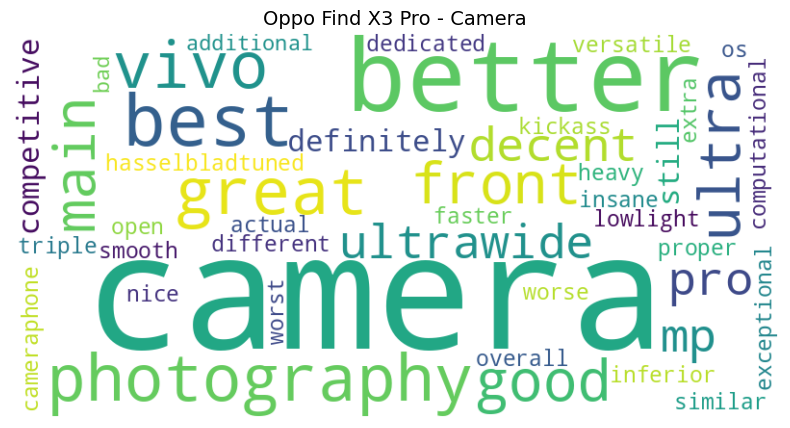

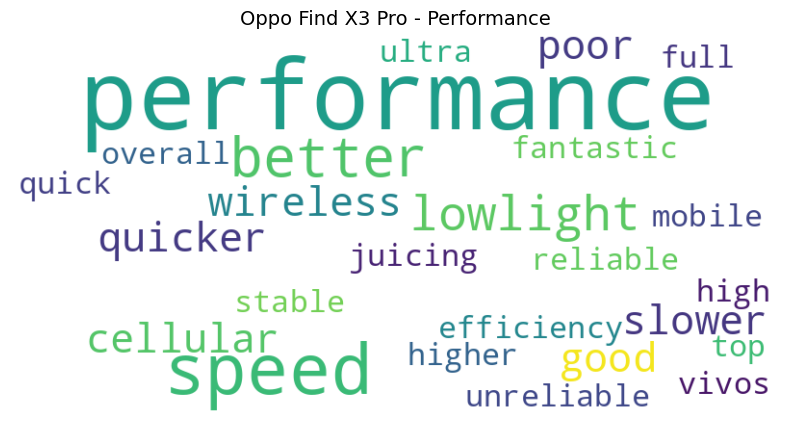

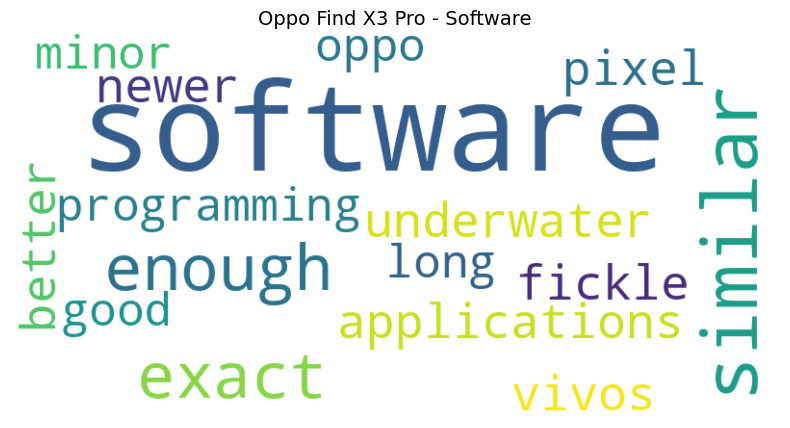

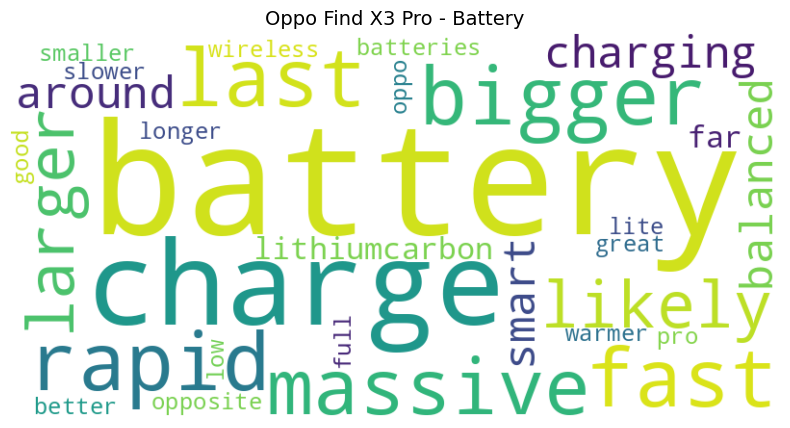

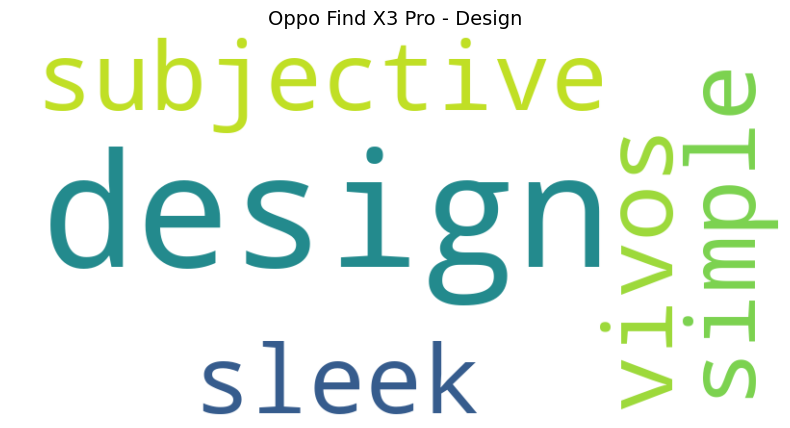

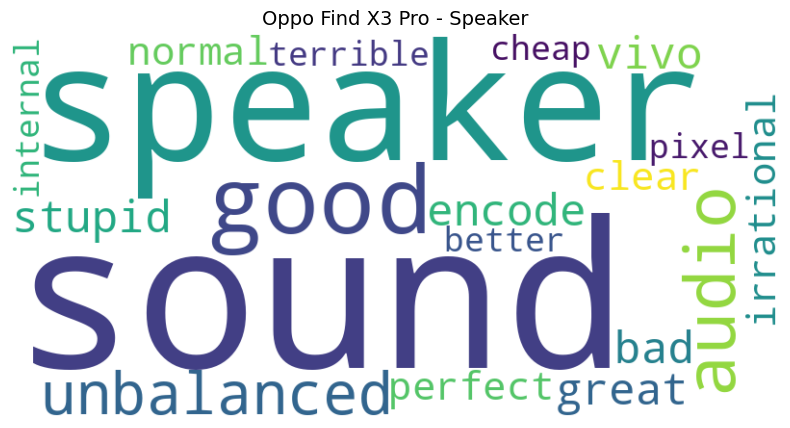

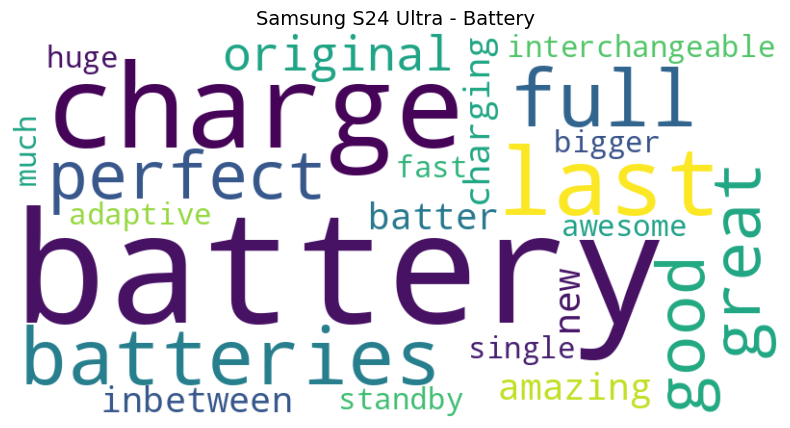

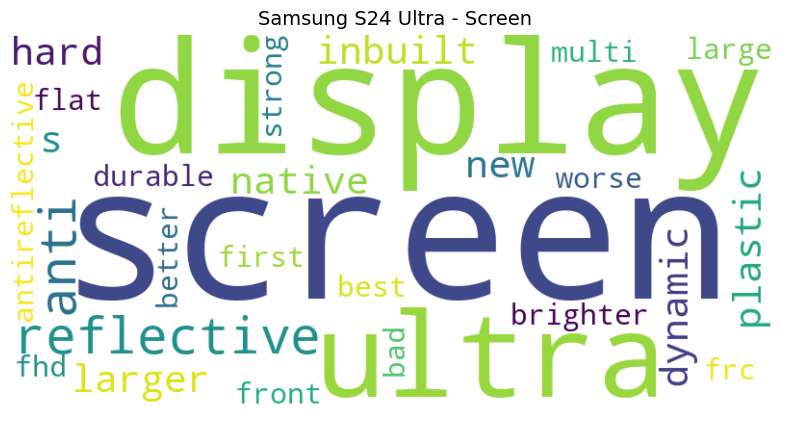

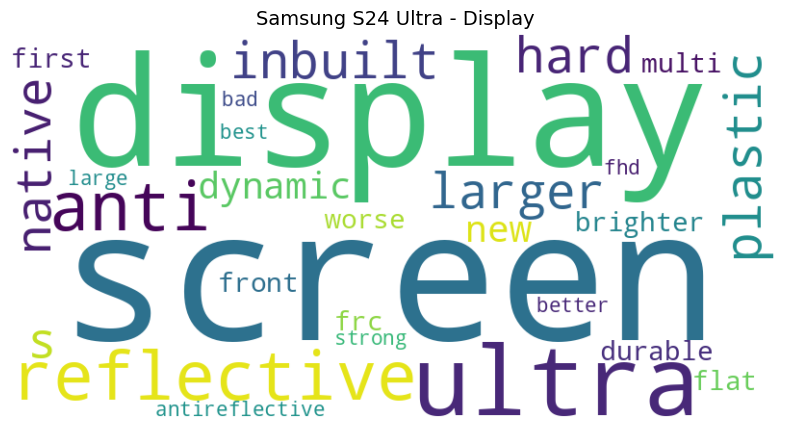

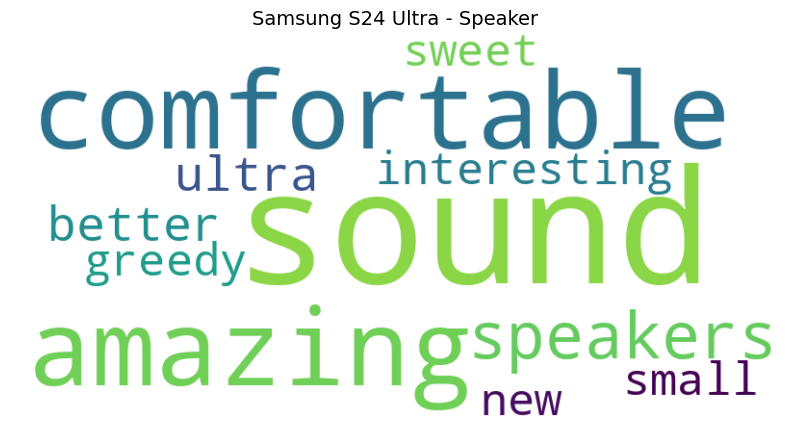

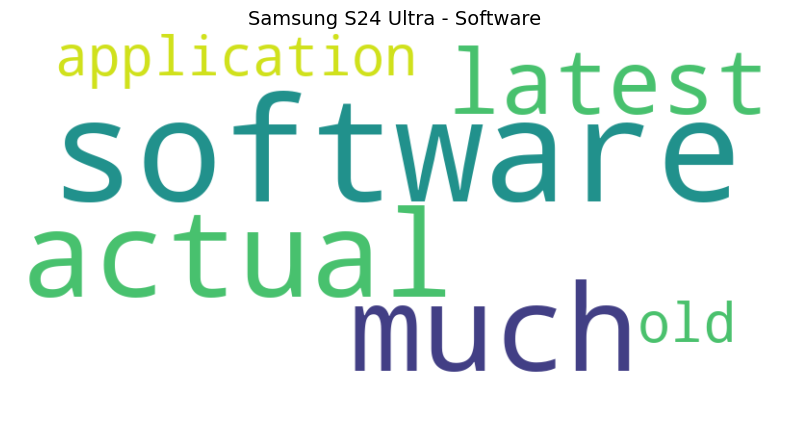

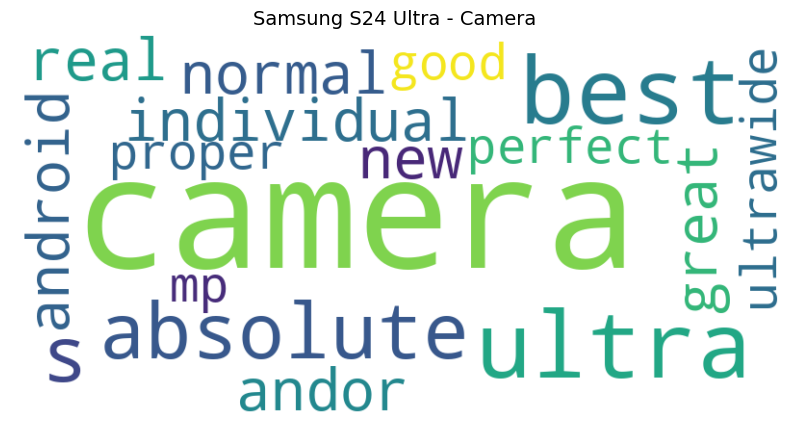

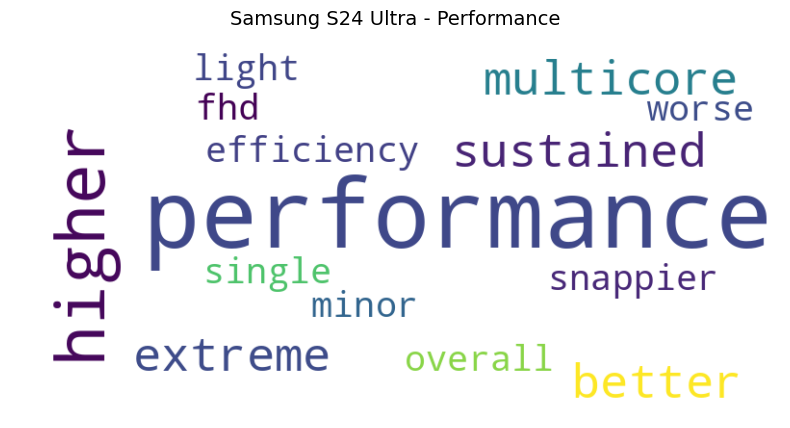

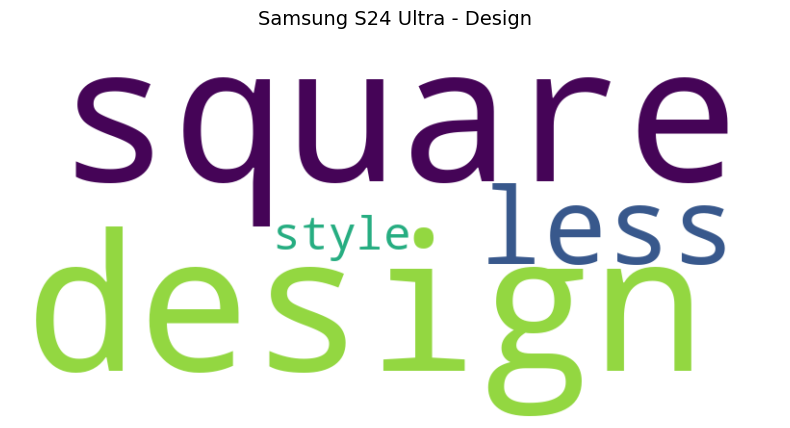

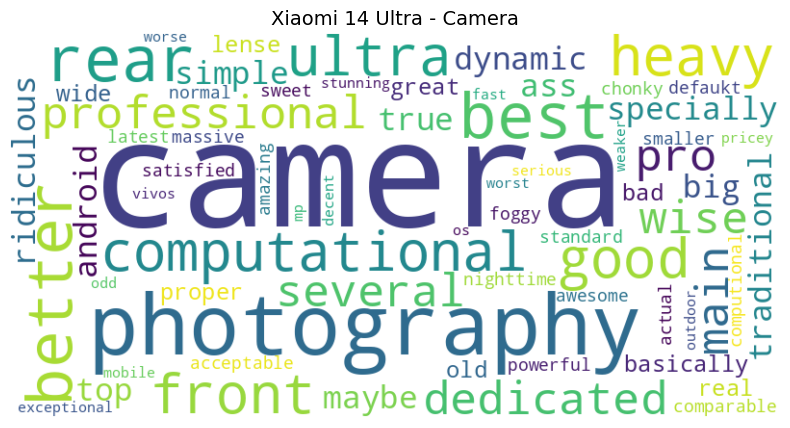

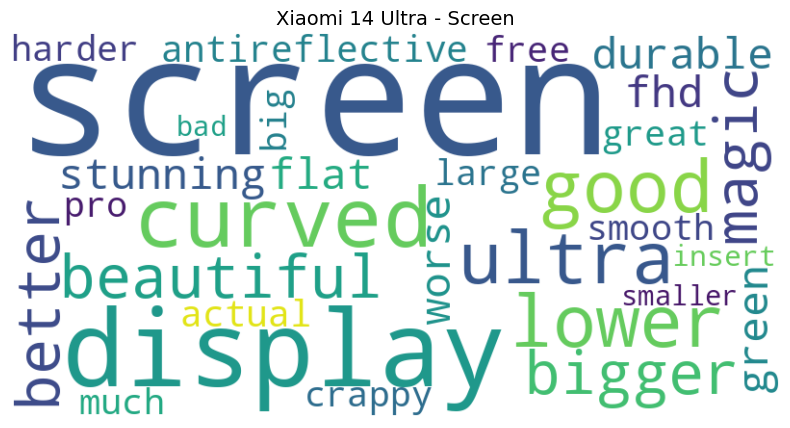

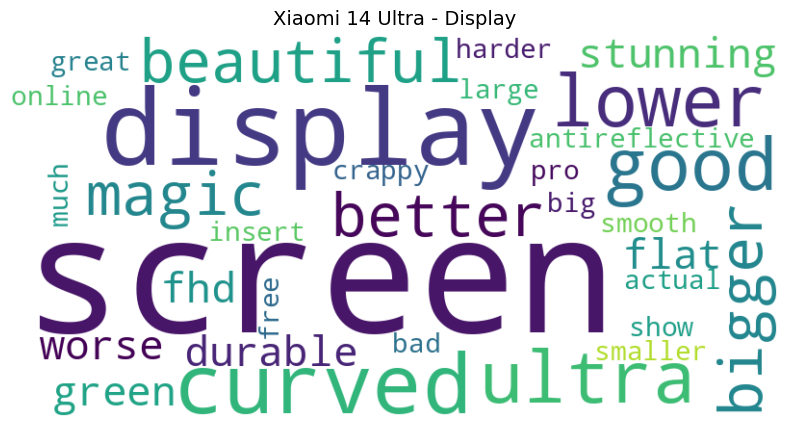

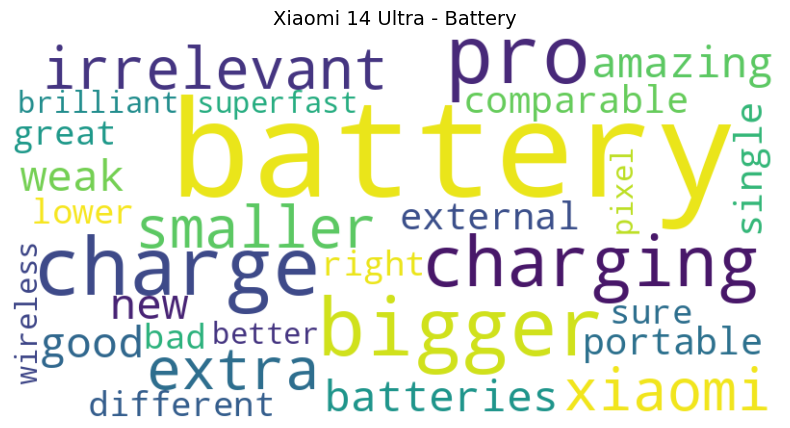

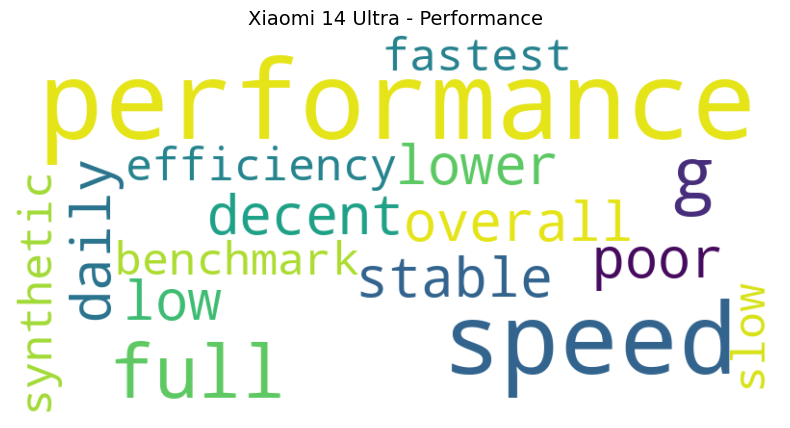

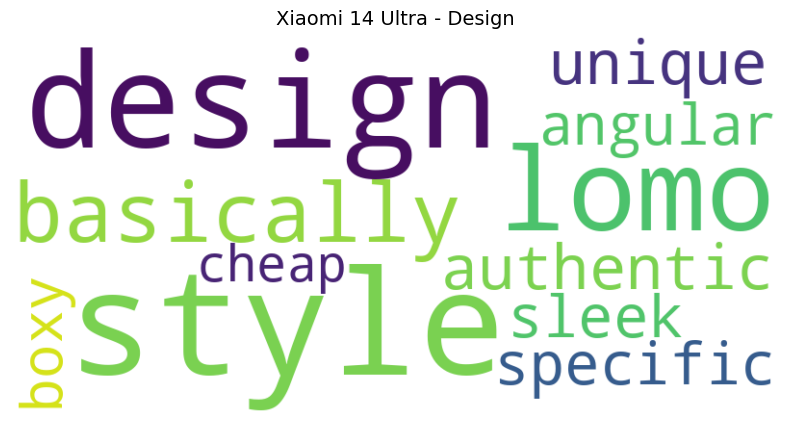

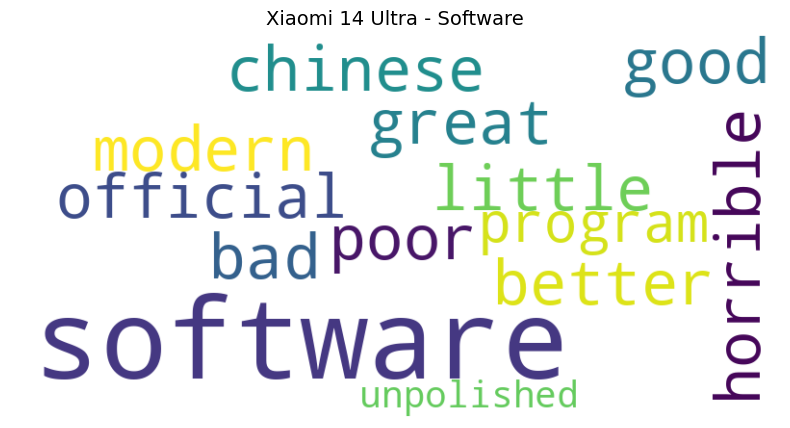

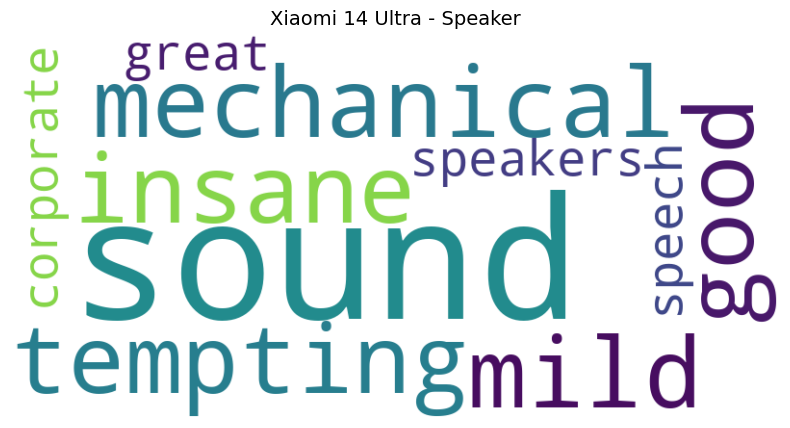

In [12]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import random

# Function to generate and display word cloud
def generate_word_cloud(ngrams, title):
    if not ngrams:
        print(f"No n-grams found for {title}")
        return

    # Convert list of n-grams to a single string
    text = " ".join(ngrams)

    # Generate word cloud
    wordcloud = WordCloud(width=800, height=400, background_color="white", colormap="viridis").generate(text)

    # Plot the word cloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(title, fontsize=14)
    plt.show()

# Generate word clouds for each brand & attribute
for brand, attributes in brandwise_results.items():
    for attribute, data in attributes.items():
        title = f"{brand} - {attribute.capitalize()}"
        generate_word_cloud(data["ngrams"], title)


# Sentiment Analysis using VADER to get Ratings for Mobile Phones

In [13]:
from collections import Counter
import pandas as pd
import numpy as np
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer

# Initialize Sentiment Analyzer
nltk.download('vader_lexicon')
sia = SentimentIntensityAnalyzer()

# Function to compute adjective frequency and sentiment scores
def compute_weighted_sentiment(brandwise_results):
    brand_sentiment = {}

    for brand, attributes in brandwise_results.items():
        attribute_scores = {}

        for attribute, data in attributes.items():
            ngrams = data["ngrams"]

            if not ngrams:  # Skip if no n-grams available
                continue

            # Count frequency of each adjective in the n-grams
            word_freq = Counter()
            sentiment_scores = []

            for ngram in ngrams:
                words = ngram.split()  # Split into individual words
                sentiment = sia.polarity_scores(ngram)["compound"]  # Get sentiment score

                for word in words:
                    word_freq[word] += 1  # Count occurrences of each word

                sentiment_scores.append((sentiment, word_freq[word]))  # Store sentiment & frequency

            # Compute weighted sentiment score
            total_weight = sum(freq for _, freq in sentiment_scores)
            weighted_sentiment = (
                sum(sent * freq for sent, freq in sentiment_scores) / total_weight if total_weight > 0 else 0
            )

            # Store attribute score
            attribute_scores[attribute] = round(weighted_sentiment, 3)

        # Compute final weighted brand score
        if attribute_scores:
            brand_sentiment[brand] = {
                "attribute_scores": attribute_scores,
                "final_brand_score": round(np.mean(list(attribute_scores.values())), 3)  # Overall brand score
            }

    return brand_sentiment

# Compute weighted sentiment scores
brand_weighted_sentiment = compute_weighted_sentiment(brandwise_results)

# Convert to DataFrame for visualization
df_weighted_sentiment = pd.DataFrame.from_dict(
    {brand: {**data["attribute_scores"], "Final Score": data["final_brand_score"]}
     for brand, data in brand_weighted_sentiment.items()}, orient='index'
)


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


# Ratings based on Sentiment Scores

In [14]:
df_weighted_sentiment

camera  performance  screen  display  battery  software  \
Google Pixel        0.229        0.054   0.179    0.178    0.119     0.181   
iPhone              0.020        0.324   0.056    0.056    0.034     0.308   
Oppo Find X3 Pro    0.110        0.027   0.127    0.127    0.101     0.068   
Samsung S24 Ultra   0.180       -0.028  -0.007   -0.007    0.232     0.000   
Xiaomi 14 Ultra     0.045       -0.137   0.093    0.093    0.077     0.025   

                   design  speaker  Final Score  
Google Pixel        0.054    0.123        0.140  
iPhone              0.000    0.357        0.144  
Oppo Find X3 Pro    0.000    0.165        0.091  
Samsung S24 Ultra   0.000    0.224        0.074  
Xiaomi 14 Ultra     0.000    0.108        0.038

# Ratings: Scaled from 1-5 to make it intuitive for the Shoppers

In [15]:
from collections import Counter
import pandas as pd
import numpy as np
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer

# Initialize Sentiment Analyzer
nltk.download('vader_lexicon')
sia = SentimentIntensityAnalyzer()

# Function to compute weighted sentiment scores on a 1-5 scale
def compute_weighted_sentiment_1to5(brandwise_results):
    brand_sentiment = {}

    for brand, attributes in brandwise_results.items():
        attribute_scores = {}

        for attribute, data in attributes.items():
            ngrams = data["ngrams"]

            if not ngrams:  # Skip if no n-grams available
                continue

            # Count frequency of each adjective in the n-grams
            word_freq = Counter()
            sentiment_scores = []

            for ngram in ngrams:
                words = ngram.split()  # Split into individual words
                sentiment = sia.polarity_scores(ngram)["compound"]  # Get sentiment score

                for word in words:
                    word_freq[word] += 1  # Count occurrences of each word

                sentiment_scores.append((sentiment, word_freq[word]))  # Store sentiment & frequency

            # Compute weighted sentiment score
            total_weight = sum(freq for _, freq in sentiment_scores)
            weighted_sentiment = (
                sum(sent * freq for sent, freq in sentiment_scores) / total_weight if total_weight > 0 else 0
            )

            # Convert to 1-5 scale
            scaled_score = 1 + ((weighted_sentiment + 1) / 2) * 4  # Transform from -1 to 1 → 1 to 5 scale
            attribute_scores[attribute] = round(scaled_score, 2)  # Round to 2 decimal places

        # Compute final weighted brand score
        if attribute_scores:
            brand_sentiment[brand] = {
                "attribute_scores": attribute_scores,
                "final_brand_score": round(np.mean(list(attribute_scores.values())), 2)  # Overall brand score
            }

    return brand_sentiment

# Compute weighted sentiment scores on a 1-5 scale
brand_weighted_sentiment_1to5 = compute_weighted_sentiment_1to5(brandwise_results)

# Convert to DataFrame for visualization
df_weighted_sentiment_1to5 = pd.DataFrame.from_dict(
    {brand: {**data["attribute_scores"], "Final Score": data["final_brand_score"]}
     for brand, data in brand_weighted_sentiment_1to5.items()}, orient='index'
)

# # Display results
# import ace_tools as tools
# tools.display_dataframe_to_user(name="Weighted Sentiment Scores (1-5 Scale)", dataframe=df_weighted_sentiment_1to5)


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [16]:
df_weighted_sentiment_1to5

camera  performance  screen  display  battery  software  \
Google Pixel         3.46         3.11    3.36     3.36     3.24      3.36   
iPhone               3.04         3.65    3.11     3.11     3.07      3.62   
Oppo Find X3 Pro     3.22         3.05    3.25     3.25     3.20      3.14   
Samsung S24 Ultra    3.36         2.94    2.99     2.99     3.46      3.00   
Xiaomi 14 Ultra      3.09         2.73    3.19     3.19     3.15      3.05   

                   design  speaker  Final Score  
Google Pixel         3.11     3.25         3.28  
iPhone               3.00     3.71         3.29  
Oppo Find X3 Pro     3.00     3.33         3.18  
Samsung S24 Ultra    3.00     3.45         3.15  
Xiaomi 14 Ultra      3.00     3.22         3.08

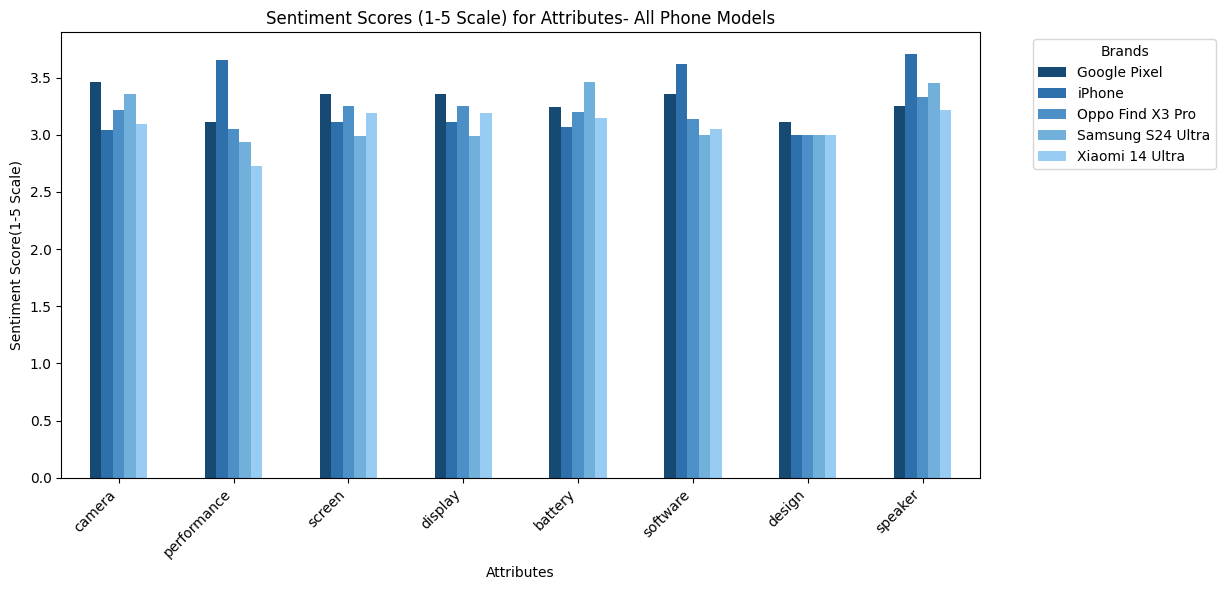

In [17]:
import matplotlib.pyplot as plt

# Transpose the DataFrame to have attributes as rows and brands as columns
df_transposed = df_weighted_sentiment_1to5.drop(columns=['Final Score']).T

# Define the extracted color palette in the desired order (Darkest → Lightest)
custom_colors = [
    (0.09, 0.29, 0.45),  # Google Pixel (Darkest Blue)
    (0.18, 0.44, 0.67),  # Oppo (Deeper Blue)
    (0.30, 0.56, 0.78),  # Samsung (Medium Blue)
    (0.44, 0.69, 0.86),  # Xiaomi (Light Blue)
    (0.60, 0.80, 0.95)   # iPhone (Lightest Blue - Adjusted for differentiation)
]

# Ensure the number of colors matches the number of brands (columns)
num_brands = len(df_transposed.columns)
colors = custom_colors[:num_brands]  # Assign colors based on the number of brands

# Create the bar plot with custom colors
ax = df_transposed.plot(kind='bar', figsize=(10, 6), color=colors)

# Customize the plot appearance
plt.title('Sentiment Scores (1-5 Scale) for Attributes- All Phone Models')
plt.xlabel('Attributes')
plt.ylabel('Sentiment Score(1-5 Scale)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.legend(title='Brands', bbox_to_anchor=(1.05, 1), loc='upper left')  # Move legend outside the plot
plt.show()


# Sentiment Analysis using BERT to get the Ratings

In [18]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import numpy as np
import pandas as pd
from collections import Counter

# Load Pretrained BERT Sentiment Model
tokenizer = AutoTokenizer.from_pretrained("nlptown/bert-base-multilingual-uncased-sentiment")
model = AutoModelForSequenceClassification.from_pretrained("nlptown/bert-base-multilingual-uncased-sentiment")

# Function to compute sentiment score using BERT (1 to 5 scale)
def get_bert_sentiment(text):
    tokens = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512)
    with torch.no_grad():
        output = model(**tokens)
    scores = torch.nn.functional.softmax(output.logits, dim=-1).numpy()[0]
    sentiment_score = np.dot(scores, np.array([1, 2, 3, 4, 5]))  # Weighted sum for scores 1-5
    return round(sentiment_score, 2)  # Round to 2 decimal places

# Function to compute weighted sentiment scores using BERT
def compute_weighted_sentiment_bert(brandwise_results):
    brand_sentiment = {}

    for brand, attributes in brandwise_results.items():
        attribute_scores = {}

        for attribute, data in attributes.items():
            ngrams = data["ngrams"]

            if not ngrams:  # Skip if no n-grams available
                continue

            # Count frequency of each n-gram
            word_freq = Counter()
            sentiment_scores = []

            for ngram in ngrams:
                sentiment = get_bert_sentiment(ngram)  # Get BERT sentiment score (1-5)

                # Count occurrences of each n-gram
                word_freq[ngram] += 1

                sentiment_scores.append((sentiment, word_freq[ngram]))  # Store sentiment & frequency

            # Compute weighted sentiment score
            total_weight = sum(freq for _, freq in sentiment_scores)
            weighted_sentiment = (
                sum(sent * freq for sent, freq in sentiment_scores) / total_weight if total_weight > 0 else 0
            )

            # Store attribute score
            attribute_scores[attribute] = round(weighted_sentiment, 2)

        # Compute final weighted brand score
        if attribute_scores:
            brand_sentiment[brand] = {
                "attribute_scores": attribute_scores,
                "final_brand_score": round(np.mean(list(attribute_scores.values())), 2)  # Overall brand score
            }

    return brand_sentiment

# Compute weighted sentiment scores using BERT
brand_weighted_sentiment_bert = compute_weighted_sentiment_bert(brandwise_results)

# Convert to DataFrame for visualization
df_weighted_sentiment_bert = pd.DataFrame.from_dict(
    {brand: {**data["attribute_scores"], "Final Score": data["final_brand_score"]}
     for brand, data in brand_weighted_sentiment_bert.items()}, orient='index'
)

In [19]:
df_weighted_sentiment_bert

camera  performance  screen  display  battery  software  \
Google Pixel         3.82         3.67    3.61     3.65     3.71      3.59   
iPhone               3.51         3.87    3.37     3.37     3.46      3.92   
Oppo Find X3 Pro     3.57         3.59    3.30     3.30     3.33      3.10   
Samsung S24 Ultra    3.98         3.00    3.52     3.52     3.93      3.46   
Xiaomi 14 Ultra      3.57         3.36    3.26     3.27     3.50      2.91   

                   design  speaker  Final Score  
Google Pixel         3.23     3.29         3.57  
iPhone               3.55     3.72         3.60  
Oppo Find X3 Pro     3.03     3.16         3.30  
Samsung S24 Ultra    3.05     3.74         3.52  
Xiaomi 14 Ultra      3.24     3.34         3.31

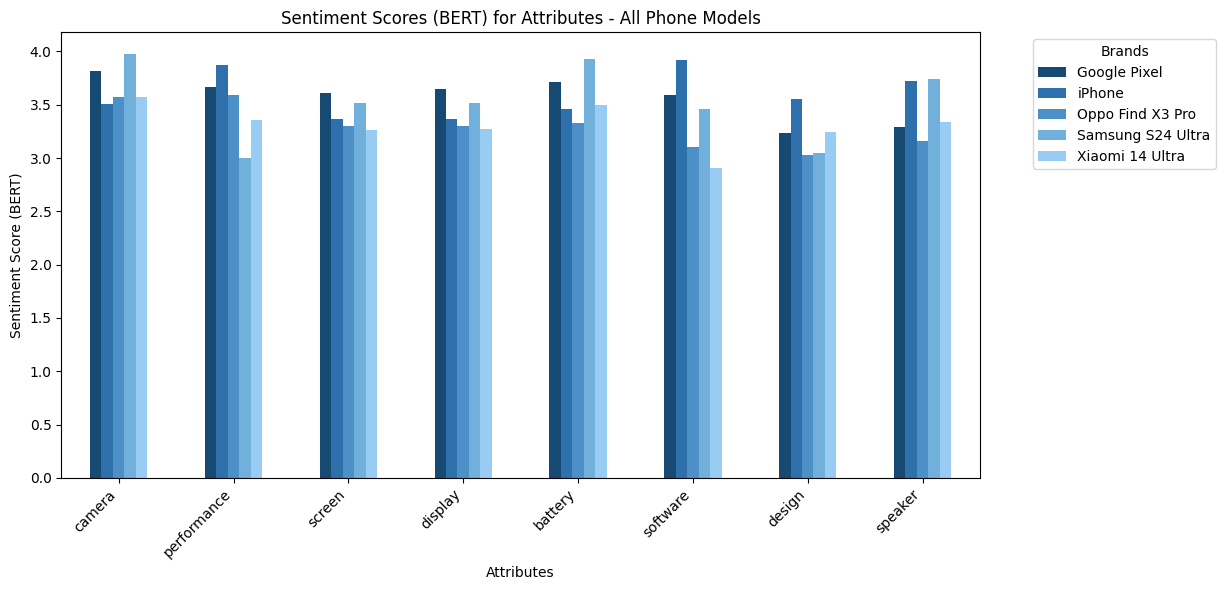

In [20]:
# Transpose the DataFrame
df_transposed = df_weighted_sentiment_bert.drop(columns=['Final Score']).T

# Define custom colors
custom_colors = [
    (0.09, 0.29, 0.45),  # Google Pixel (Darkest Blue)
    (0.18, 0.44, 0.67),  # Oppo (Deeper Blue)
    (0.30, 0.56, 0.78),  # Samsung (Medium Blue)
    (0.44, 0.69, 0.86),  # Xiaomi (Light Blue)
    (0.60, 0.80, 0.95)   # iPhone (Lightest Blue - Adjusted for differentiation)
]

# Ensure colors match the number of brands
num_brands = len(df_transposed.columns)
colors = custom_colors[:num_brands]

# Create the bar plot
ax = df_transposed.plot(kind='bar', figsize=(10, 6), color=colors)

# Customize the plot
plt.title('Sentiment Scores (BERT) for Attributes - All Phone Models')
plt.xlabel('Attributes')
plt.ylabel('Sentiment Score (BERT)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.legend(title='Brands', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


# Sentiment Analysis using TextBlob to Ratings

In [21]:
from textblob import TextBlob

# Function to compute sentiment score using TextBlob
def get_textblob_sentiment(text):
    analysis = TextBlob(text)
    return analysis.sentiment.polarity

# Function to compute weighted sentiment scores using TextBlob
def compute_weighted_sentiment_textblob(brandwise_results):
    brand_sentiment = {}
    for brand, attributes in brandwise_results.items():
        attribute_scores = {}
        for attribute, data in attributes.items():
            ngrams = data["ngrams"]
            if not ngrams:
                continue
            word_freq = Counter()
            sentiment_scores = []
            for ngram in ngrams:
                sentiment = get_textblob_sentiment(ngram)
                word_freq[ngram] += 1
                sentiment_scores.append((sentiment, word_freq[ngram]))
            total_weight = sum(freq for _, freq in sentiment_scores)
            weighted_sentiment = (
                sum(sent * freq for sent, freq in sentiment_scores) / total_weight if total_weight > 0 else 0
            )
            attribute_scores[attribute] = round(weighted_sentiment, 2)
        if attribute_scores:
            brand_sentiment[brand] = {
                "attribute_scores": attribute_scores,
                "final_brand_score": round(np.mean(list(attribute_scores.values())), 2)
            }
    return brand_sentiment

# Compute weighted sentiment scores using TextBlob
brand_weighted_sentiment_textblob = compute_weighted_sentiment_textblob(brandwise_results)

# Convert to DataFrame for visualization
df_weighted_sentiment_textblob = pd.DataFrame.from_dict(
    {brand: {**data["attribute_scores"], "Final Score": data["final_brand_score"]}
     for brand, data in brand_weighted_sentiment_textblob.items()}, orient='index'
)

df_weighted_sentiment_textblob


camera  performance  screen  display  battery  software  \
Google Pixel         0.30         0.16    0.19     0.20     0.24      0.13   
iPhone               0.12         0.27    0.09     0.09     0.09      0.41   
Oppo Find X3 Pro     0.22         0.17    0.16     0.16     0.12      0.08   
Samsung S24 Ultra    0.27         0.08    0.04     0.04     0.30      0.12   
Xiaomi 14 Ultra      0.15         0.01    0.17     0.17     0.09     -0.01   

                   design  speaker  Final Score  
Google Pixel         0.07     0.13         0.18  
iPhone               0.04     0.15         0.16  
Oppo Find X3 Pro     0.00     0.24         0.14  
Samsung S24 Ultra   -0.08     0.33         0.14  
Xiaomi 14 Ultra      0.13     0.17         0.11

In [23]:
# Assuming df_weighted_sentiment_textblob is already defined as in your provided code

def scale_scores(df):
    """Scales scores in a DataFrame to a 1-5 range."""

    # Assuming scores are in columns other than 'Final Score'
    for col in df.columns:
      if col != 'Final Score':
        df[col] = 1 + ((df[col] + 1) / 2) * 4
        df[col] = df[col].clip(lower=1, upper=5) # Ensure scores stay within 1-5
    return df

df_weighted_sentiment_textblob = scale_scores(df_weighted_sentiment_textblob)
df_weighted_sentiment_textblob


camera  performance  screen  display  battery  software  \
Google Pixel         3.60         3.32    3.38     3.40     3.48      3.26   
iPhone               3.24         3.54    3.18     3.18     3.18      3.82   
Oppo Find X3 Pro     3.44         3.34    3.32     3.32     3.24      3.16   
Samsung S24 Ultra    3.54         3.16    3.08     3.08     3.60      3.24   
Xiaomi 14 Ultra      3.30         3.02    3.34     3.34     3.18      2.98   

                   design  speaker  Final Score  
Google Pixel         3.14     3.26         0.18  
iPhone               3.08     3.30         0.16  
Oppo Find X3 Pro     3.00     3.48         0.14  
Samsung S24 Ultra    2.84     3.66         0.14  
Xiaomi 14 Ultra      3.26     3.34         0.11

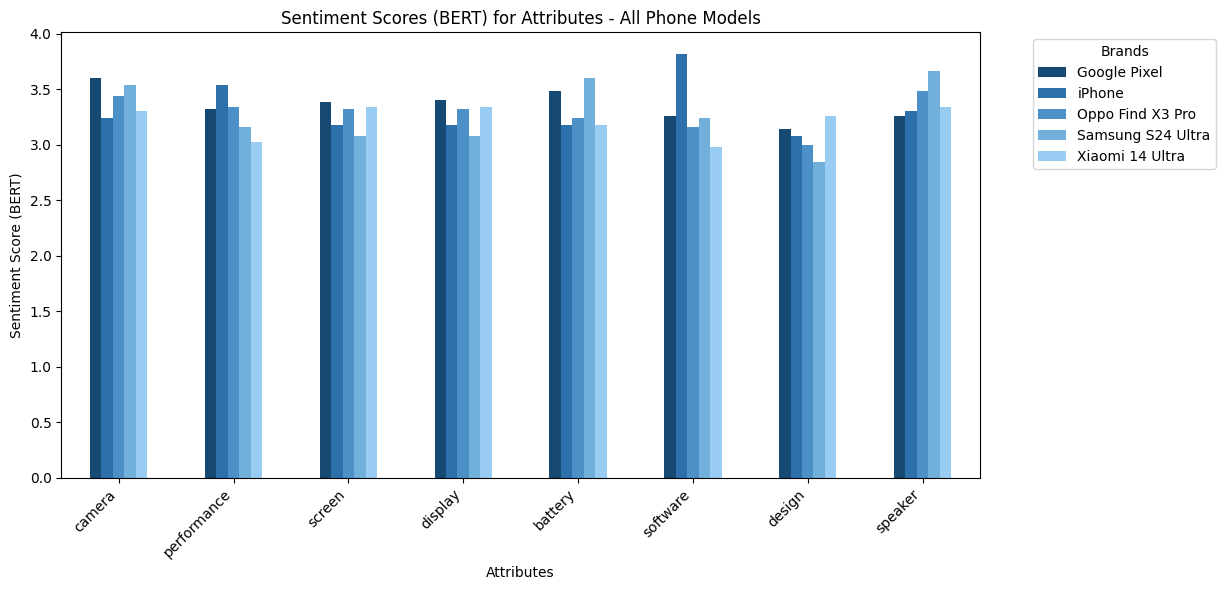

In [24]:
# Transpose the DataFrame
df_transposed = df_weighted_sentiment_textblob.drop(columns=['Final Score']).T

# Define custom colors
custom_colors = [
    (0.09, 0.29, 0.45),  # Google Pixel (Darkest Blue)
    (0.18, 0.44, 0.67),  # Oppo (Deeper Blue)
    (0.30, 0.56, 0.78),  # Samsung (Medium Blue)
    (0.44, 0.69, 0.86),  # Xiaomi (Light Blue)
    (0.60, 0.80, 0.95)   # iPhone (Lightest Blue - Adjusted for differentiation)
]

# Ensure colors match the number of brands
num_brands = len(df_transposed.columns)
colors = custom_colors[:num_brands]

# Create the bar plot
ax = df_transposed.plot(kind='bar', figsize=(10, 6), color=colors)

# Customize the plot
plt.title('Sentiment Scores (BERT) for Attributes - All Phone Models')
plt.xlabel('Attributes')
plt.ylabel('Sentiment Score (BERT)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.legend(title='Brands', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


### Correlation between sentiment scores from multiple models - VADER, TextBlob, BERT

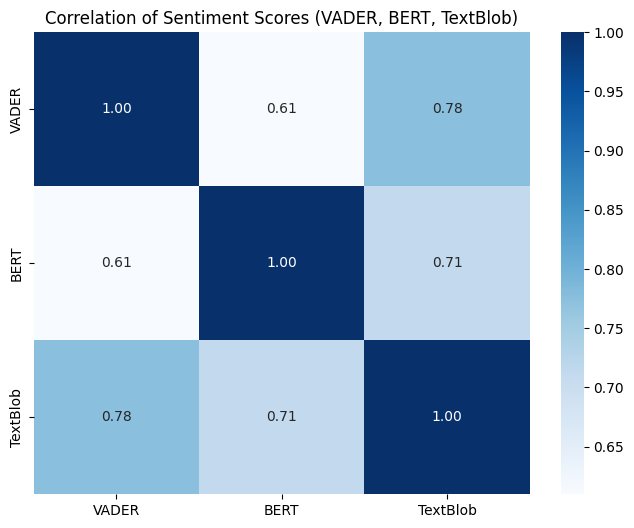

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_correlation(df_vader, df_bert, df_textblob):

    # Combine sentiment scores into a single DataFrame for easier correlation analysis
    combined_df = pd.DataFrame({
      'VADER': df_vader.values.flatten(),
      'BERT': df_bert.values.flatten(),
      'TextBlob': df_textblob.values.flatten()
    })

    # Calculate the correlation matrix
    correlation_matrix = combined_df.corr()

    # Create a heatmap using Seaborn
    plt.figure(figsize=(8, 6))
    sns.heatmap(correlation_matrix, annot=True, cmap="Blues", fmt=".2f")
    plt.title("Correlation of Sentiment Scores (VADER, BERT, TextBlob)")
    plt.show()


df_vader = df_weighted_sentiment_1to5.drop(columns=['Final Score']).T
df_textblob = df_weighted_sentiment_textblob.drop(columns=['Final Score']).T
df_bert = df_weighted_sentiment_bert.drop(columns=['Final Score']).T

plot_correlation(df_vader, df_bert, df_textblob)
